In [2]:
import numpy as np 
import msprime
from scipy import linalg, stats
import utils
import matplotlib.pyplot as plt 
import seaborn as sns 
import pysam
import pandas as pd
from typing import Callable

np.random.seed(42)

# Setup

## Simulate data and clean real data

In [ ]:
# Clean old data

vcf_path = "raw_data/ALL.chr21.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz"
vcf_file = pysam.VariantFile(vcf_path)

records = [record for record in vcf_file.fetch()]


# Filter data

#16 minutes: 154k observations
filtered_by_maf = utils.filter_maf(records)
#2 minutes: no change
filtered_by_missingness = utils.filter_missingness(filtered_by_maf)
#13 seconds: no change
filtered_by_quality = utils.filter_quality(filtered_by_missingness)

records = filtered_by_quality

# Getting the number of samples and SNPs
num_samples = len(vcf_file.header.samples)
num_snps = len(records)

# Create an empty genotype matrix
G = np.empty((num_samples, num_snps), dtype=int)

# Fill the matrix
for j, record in enumerate(records):
    for i, sample in enumerate(vcf_file.header.samples):
        genotype = record.samples[sample].allele_indices
        # Biallelic SNPs
        if genotype == (0, 0):
            G[i][j] = 0
        elif genotype in [(0, 1), (1, 0)]:
            G[i][j] = 1
        else:
            G[i][j] = 2


U, S, Vt = np.linalg.svd(G, full_matrices = False)

np.savez_compressed("../processed_data/real/ALL.chr21.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes)_SVD.npz", U = U, S = S, Vt = Vt)
np.savez_compressed("../processed_data/real/ALL.chr21.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.npz", G)

In [ ]:
# We simulate data of various sizes, sequence lengths, and sparsities
sample_sizes = [50, 200, 1000, 10000]
sequence_lengths = [10**x for x in range(4, 8)]
mutation_rates = [1e-4, 1e-6, 1e-8] #lower mutation rate = sparser
recombination_rate = 1e-7

G_simulated = {}

for n in sample_sizes:
    for length in sequence_lengths:
        for mut_rate in mutation_rates:
            G = utils.simulate_diploid_genotypes(n, length, mut_rate, recombination_rate)
            if G.shape[1] >= 10:
                G_simulated[(n, length, mut_rate)] = G

In [ ]:
# Save simulated data
data_dir = "../processed_data/simulated"
for (params, G) in G_simulated.items():
    file_name = f"{params[0]}_{params[1]}_{params[2]}.genotypes.npz"
    np.savez_compressed(f"{data_dir}/{file_name}", G)

## Load Data 

In [28]:
# Real data from 1000 genomes project
G = np.load("../processed_data/real/ALL.chr21.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.npz")['arr_0']
svd_data = np.load("../processed_data/real/ALL.chr21.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes)_SVD.npz")

U, S, Vt = svd_data["U"], svd_data["S"], svd_data["Vt"]

In [3]:
# Load simulated data

sample_sizes = [50, 200, 1000, 10000]
sequence_lengths = [10**x for x in range(4, 8)] 
mutation_rates = [1e-4, 1e-6, 1e-8] #lower mutation rate = sparser
recombination_rate = 1e-7

G_simulated = {}

simulated_dir = "../processed_data/simulated/"
for n in sample_sizes:
    for length in sequence_lengths:
        for mut_rate in mutation_rates:
            file_name = f"{n}_{length}_{mut_rate}.genotypes.npz"
            file_dir = simulated_dir + file_name 
            try:
                G = np.load(file_dir)["arr_0"]
                G_simulated[(n, length, mut_rate)] = G
            except:
                continue

## Summary Statistics

In [3]:
# Calculate sparsity statistics for G
utils.count_genotypes(G)

(0.8687659722222222, 0.09020671296296297, 0.041027314814814815)

In [46]:
# Calculate sparsity statistics
G_simulated_props = {key: utils.count_genotypes(G_simulated[key]) for key in G_simulated.keys()}

In [47]:
# Generate dataframe
df_keys = [{'Parameters': key, 'Shape of G': G_simulated[key].shape,
         'Proportion Zeros': value[0], 'Proportion Ones': value[1], 'Proportion Twos': value[2]}
        for key, value in G_simulated_props.items()]

G_df = pd.DataFrame(df_keys)

# Write to LaTeX
with open('../output/sim_data_table.txt', 'w') as f:
    f.write(G_df.to_latex(index=False,
                          bold_rows=False,
                          float_format="%.2f"))

G_df

,Parameters,Shape of G,Proportion Zeros,Proportion Ones,Proportion Twos
0,"(50, 10000, 0.0001)","(50, 15)",0.537333,0.156000,0.306667
1,"(50, 100000, 0.0001)","(50, 204)",0.784216,0.154314,0.061471
2,"(50, 1000000, 0.0001)","(50, 1889)",0.761207,0.189137,0.049656
3,"(50, 1000000, 1e-06)","(50, 35)",0.668571,0.224571,0.106857
4,"(50, 10000000, 0.0001)","(50, 17331)",0.786631,0.176902,0.036468
5,"(50, 10000000, 1e-06)","(50, 232)",0.752931,0.181121,0.065948
6,"(200, 10000, 0.0001)","(200, 22)",0.693864,0.147500,0.158636
7,"(200, 100000, 0.0001)","(200, 178)",0.901348,0.088399,0.010253
8,"(200, 1000000, 0.0001)","(200, 2049)",0.853675,0.114422,0.031903
9,"(200, 1000000, 1e-06)","(200, 20)",0.627750,0.295750,0.076500


# Algorithms

## Darnell et al: ARSVD

Paper: https://www.jmlr.org/papers/volume18/15-143/15-143.pdf 

Implementation: https://github.com/gdarnell/arsvd/blob/master/dimension_reduction.py 


In [3]:
def rsvd(X, dstar, power_iters=2, delta=10):
	""" Perform rsvd algorithm on input matrix.
		Method must be supplied dstar.
		Returns truncated svd (U,S,V).
	Parameters
	----------
	X : int matrix
    	Matrix of n x m integers, where m <= n. If n < m,
    	matrix will be transposed to enforce m <= n.
   	dstar : int
   		The latent (underlying) matrix rank that will be
   		used to truncate the larger dimension (m).
   	power_iters : int
   		default: 2
   		Number of power iterations used (random matrix multiplications)
   	delta : int
   		default: 10
   		oversampling parameter (to improve numerical stability)
    Returns
	-------
	int matrix
    	Matrix of left singular vectors.
    int matrix
    	Matrix of singular values.
    int matrix
    	Matrix of right singular vectors.
    """
	transpose = False 
	if X.shape[0] < X.shape[1]:
		X = X.T 
		transpose = True 

	if power_iters < 1:
		power_iters = 1

	# follows manuscript notation as closely as possible
	P = np.random.randn(X.shape[0],dstar+delta)	
	for i in range(power_iters):
		P = np.dot(X.T,P)
		P = np.dot(X,P)
	Q,R = np.linalg.qr(P)
	B = np.dot(Q.T,X)
	U,S,V = linalg.svd(B)
	U = np.dot(Q, U)

	# Remove extra dimensionality incurred by delta
	U = U[:, 0:dstar]
	S = S[0:dstar]

	return (V.T, S, U.T) if transpose else (U, S, V)


def stabilityMeasure(X, d_max, B=5, power_iters=2):
	""" Calculate stability of 
	Parameters
	----------
	X : int matrix
		input matrix to determine rank of
	d_max : int
		upper bound rank to estimate
	B : int
		default: 5
		number of projections to correlate
	power_iters : int
		default: 2
   		Number of power iterations used (random matrix multiplications)
	Returns
	-------
	int
		Latent (lower-dimensional) matrix rank
	"""
	singular_basis = np.zeros((B,X.shape[0],d_max))
	# calculate singular basis under multiple projections
	for i in range(B):
		U = rsvd(X,d_max)[0]
		singular_basis[i,:,:] = U[:,0:d_max]

	# calculate score for each singular vector
	stability_vec = np.zeros((d_max))
	for k in range(d_max):
		stability = 0
		for i in range(0,B-1):
			for j in range(i+1,B):
				corr = stats.spearmanr(singular_basis[i,:,k],singular_basis[j,:,k])[0]
				stability = stability + abs(corr)
		N = B*(B-1)/2
		stability = stability/N
		stability_vec[k] = stability

	# wilcoxon rank-sum test p-values
	p_vals = np.zeros(d_max-2)
	for k in range(2,d_max):
		p_vals[k-2] = stats.ranksums(stability_vec[0:k-1],stability_vec[k-1:d_max])[1]

	dstar = np.argmin(p_vals)
	
	return dstar

## Saibaba et al: GSVD

Paper: https://www.osti.gov/servlets/purl/1769894 

In [4]:
def gsvd():
    pass 

## Galinsky et al: FastPCA 

Paper: https://www.sciencedirect.com/science/article/pii/S0002929716000033


In [4]:
def center_X(X: np.array):
    """ 
    Returns a centered version of X so that each column has mean 0.

    Input:
    - X (2D numpy array): dataset

    Returns:
    - Xtilde, centered version of X
    """
    return X - np.mean(X, axis = 0)

def normalize_X(X: np.array):
    """ 
    Normalizes X so each column has variance 1.

    Input: 
    - X (2D numpy array): dataset (assumed to be centered)

    Returns: 
    - Xtilde, normalized version of X
    """
    sd = np.std(X, axis = 0)
    return X/sd
    

In [5]:
def fastpca(G, k: int, I: int = 10):
    """ 
    Our implementation of the FastPCA algorithm in Python. 

    Inputs:
    - G (2D numpy array): the genotype matrix
    - k (int): the desired number of principal components
    - I (int): the number of iterations

    Returns:
    - top k principal components
    """
    n, p = G.shape[0], G.shape[1]
    # Normalize G
    Y = center_X(G)
    Y = normalize_X(Y)

    # Generate random matrix P0
    l = 2 * k # as suggested by the Galinsky paper
    P_i = np.random.randn(p, l) #P_0 in the paper; initializing step

    H_matrices = []

    # Update rule: H_i = Y*P_i, P_{i+1} = 1/n * Y^T * H_i
    for _ in range(I):
        H_i = Y @ P_i
        P_i = 1/n * Y.T @ H_i 
        H_matrices.append(H_i)

    H = np.concatenate(H_matrices, axis = 1)

    # Compute SVD of H
    U_H, _, _ = np.linalg.svd(H)

    T = U_H.T @ Y

    _, _, VT_T = np.linalg.svd(T) 

    return VT_T[:k, :].T    

# Benchmarking

In [9]:
def benchmark(f: Callable, k: int, data: dict, *args):
    """ 
    Benchmarks performance of an algorithm on the given datasets.

    Inputs:
    - f (Callable): the PCA algorithm
        - should take in an argument for data and an argument for number of principal components
    - k (int): the desired number of principal components
    - data (dict): the datasets, where data[params] = dataset

    Returns:
    - dict of accuracy metrics by dataset
    """
    accuracy_metrics = {}
    for (params, dataset) in data.items():

        """
        # FastPCA times out when attempting to compute an SVD for this matrix
            # Takes > 1 hour for just 1 repetition for k values
        if dataset.shape in [(1000, 34599), (10000, 3618), (10000, 41561)]:
            print(f"Skipping dataset with shape {dataset.shape} for k = {k}")
            continue 
        """
        # Calculate proportion of total variance for top k PCs
        accuracy_key = (params, k)
        pcs = f(dataset, k, *args)
        
        accuracy_metrics[accuracy_key] = utils.compute_prop_variance(pcs, dataset)

    return accuracy_metrics

def benchmark_1000_genomes(f: Callable, k: int, data: dict, *args):
    """ 
    Benchmarks performance of an algorithm on the given datasets.

    Inputs:
    - f (Callable): the PCA algorithm
        - should take in an argument for data and an argument for number of principal components
    - k (int): the desired number of principal components
    - data (dict): the datasets, where data[params] = dataset

    Returns:
    - dict of accuracy metrics by dataset
    """

In [7]:
# Values for k
k_vals = [2, 3, 5, 10]

num_repetitions = 2

### ARSVD

In [14]:
def pca_arsvd(X, k, dstar):
    transpose = False 
    # Check if transposing is necessary
    if X.shape[0] < X.shape[1]:
        X = X.T 
        transpose = True 
        VT, _, _ = rsvd(X, dstar)
    else:
        _, _, V = rsvd(X, dstar)

    
    # Compute top k pcs
    Xtilde = center_X(X)

    pcs = []

    if transpose:
        for i in range(min(dstar, k)):
            pc = VT[:, i]
            pcs.append(pc)
    else:
        for i in range(min(dstar, k)):
            pc = V[i, :]
            pcs.append(pc)
    
    return np.array(pcs).T

In [17]:
# Benchmarking
arsvd_benchmark = []

for i in range(num_repetitions):
    print(f"Starting repetition {i + 1}")
    benchmark_totals = []
    for k in k_vals:
        results = benchmark(pca_arsvd, k, G_simulated, 10)
        benchmark_totals.append(results)
    arsvd_benchmark.append(benchmark_totals)

Starting repetition 1
Starting repetition 2


In [44]:
# Average values across trials 
arsvd_avgs = {}

for i, k in enumerate(k_vals):
    for key in arsvd_benchmark[0][i].keys():
        avg = (arsvd_benchmark[0][i][key] + arsvd_benchmark[1][i][key])/2
        arsvd_avgs[key] = avg 

In [67]:
# Save average values
df = pd.DataFrame.from_dict(arsvd_avgs, orient = 'index', columns = ['Value'])

# Reset index to separate tuple keys into columns
df.reset_index(inplace=True)
df.rename(columns={'index': 'Tuple_Key'}, inplace=True)

# Split the tuple keys into separate columns
df[['Tuple_1', 'k']] = pd.DataFrame(df['Tuple_Key'].tolist())
df[['n', 'sequence_length', 'mut_rate']] = pd.DataFrame(df['Tuple_1'].tolist())

# Drop the original Tuple_Key column
df.drop(columns=['Tuple_Key', 'Tuple_1'], inplace=True)

df = df[['n', 'sequence_length', 'mut_rate', 'k', 'Value']]

# Split by value of k
df_2 = df[df['k'] == 2]
df_3 = df[df['k'] == 3]
df_5 = df[df['k'] == 5]
df_10 = df[df['k'] == 10]

In [70]:
# Save values
df_2.to_csv("../outputrsvd_2.csv")
df_3.to_csv("../output/arsvd_3.csv")
df_5.to_csv("../output/arsvd_5.csv")
df_10.to_csv("../output/arsvd_10.csv")

### FastPCA

In [10]:
# Benchmarking
fastpca_benchmark = []

for i in range(num_repetitions):
    print(f"Starting repetition {i + 1}") 
    benchmark_totals = []
    for k in k_vals:
        print(f"Starting k = {k}")
        results = benchmark(fastpca, k, G_simulated)
        benchmark_totals.append(results)
    fastpca_benchmark.append(benchmark_totals)

Starting repetition 1
Starting k = 2
Skipping dataset with shape (1000, 34599) for k = 2
Skipping dataset with shape (10000, 3618) for k = 2
Skipping dataset with shape (10000, 41561) for k = 2
Starting k = 3
Skipping dataset with shape (1000, 34599) for k = 3
Skipping dataset with shape (10000, 3618) for k = 3
Skipping dataset with shape (10000, 41561) for k = 3
Starting k = 5
Skipping dataset with shape (1000, 34599) for k = 5
Skipping dataset with shape (10000, 3618) for k = 5
Skipping dataset with shape (10000, 41561) for k = 5
Starting k = 10
Skipping dataset with shape (1000, 34599) for k = 10
Skipping dataset with shape (10000, 3618) for k = 10
Skipping dataset with shape (10000, 41561) for k = 10
Starting repetition 2
Starting k = 2
Skipping dataset with shape (1000, 34599) for k = 2
Skipping dataset with shape (10000, 3618) for k = 2
Skipping dataset with shape (10000, 41561) for k = 2
Starting k = 3
Skipping dataset with shape (1000, 34599) for k = 3
Skipping dataset with sha

In [11]:
# Average values across trials 
fastpca_avgs = {}

for i, k in enumerate(k_vals):
    for key in fastpca_benchmark[0][i].keys():
        avg = (fastpca_benchmark[0][i][key] + fastpca_benchmark[1][i][key])/2
        fastpca_avgs[key] = avg 

In [12]:
# Save average values
df = pd.DataFrame.from_dict(fastpca_avgs, orient = 'index', columns = ['Value'])

# Reset index to separate tuple keys into columns
df.reset_index(inplace=True)
df.rename(columns={'index': 'Tuple_Key'}, inplace=True)

# Split the tuple keys into separate columns
df[['Tuple_1', 'k']] = pd.DataFrame(df['Tuple_Key'].tolist())
df[['n', 'sequence_length', 'mut_rate']] = pd.DataFrame(df['Tuple_1'].tolist())

# Drop the original Tuple_Key column
df.drop(columns=['Tuple_Key', 'Tuple_1'], inplace=True)

df = df[['n', 'sequence_length', 'mut_rate', 'k', 'Value']]

# Split by value of k
df_2 = df[df['k'] == 2]
df_3 = df[df['k'] == 3]
df_5 = df[df['k'] == 5]
df_10 = df[df['k'] == 10]

In [13]:
# Save values
df_2.to_csv("../output/fastpca_2.csv")
df_3.to_csv("../output/fastpca_3.csv")
df_5.to_csv("../output/fastpca_5.csv")
df_10.to_csv("../output/fastpca_10.csv")

# Visualization

In [16]:
# Read in data
arsvd_2 = pd.read_csv("../output/arsvd_2.csv")
arsvd_3 = pd.read_csv("../output/arsvd_3.csv")
arsvd_5 = pd.read_csv("../output/arsvd_5.csv")
arsvd_10 = pd.read_csv("../output/arsvd_10.csv")

fastpca_2 = pd.read_csv("../output/fastpca_2.csv")
fastpca_3 = pd.read_csv("../output/fastpca_3.csv")
fastpca_5 = pd.read_csv("../output/fastpca_5.csv")
fastpca_10 = pd.read_csv("../output/fastpca_10.csv")

In [25]:
# Averaging performance across all datasets per k
arsvd_avgs = [arsvd_2["Value"].mean(), arsvd_3["Value"].mean(), arsvd_5["Value"].mean(), arsvd_10["Value"].mean()]
fastpca_avgs = [fastpca_2["Value"].mean(), fastpca_3["Value"].mean(), fastpca_5["Value"].mean(), fastpca_10["Value"].mean()]

In [31]:
# Averaging performance across all datasets per k, dropping 3 ARSVD datapoints
    # Dropping datasets that ARSVD got answers for that FastPCA couldn't
    # Indices 16, 20, 22 represent the big datasets we couldn't generate FastPCA results for
dropped_arsvd_2 = arsvd_2.drop([16, 20, 22])
dropped_arsvd_3 = arsvd_3.drop([16, 20, 22])
dropped_arsvd_5 = arsvd_5.drop([16, 20, 22])
dropped_arsvd_10 = arsvd_10.drop([16, 20, 22])

dropped_arsvd_avgs = [dropped_arsvd_2["Value"].mean(), dropped_arsvd_3["Value"].mean(), dropped_arsvd_5["Value"].mean(), dropped_arsvd_10["Value"].mean()]
fastpca_avgs = [fastpca_2["Value"].mean(), fastpca_3["Value"].mean(), fastpca_5["Value"].mean(), fastpca_10["Value"].mean()]

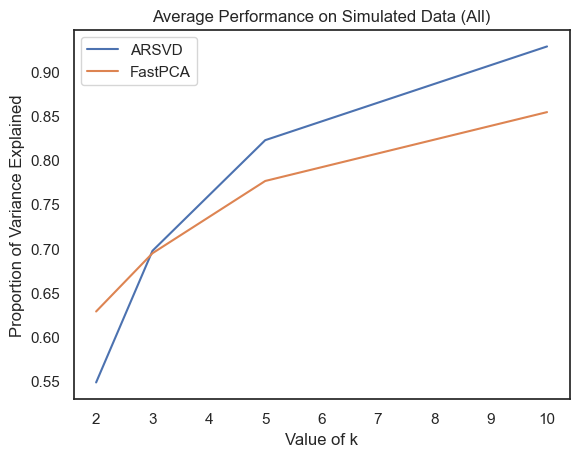

In [44]:
# Averages (no datasets dropped)
figure_dir = "../output/figures"
plt.plot(k_vals, arsvd_avgs, label = "ARSVD")
plt.plot(k_vals, fastpca_avgs, label = "FastPCA")
plt.xlabel("Value of k")
plt.ylabel("Proportion of Variance Explained")
plt.title("Average Performance on Simulated Data (All)")
plt.legend()

plt.savefig(f"{figure_dir}/all_arsvd_fastpca_avg.png")

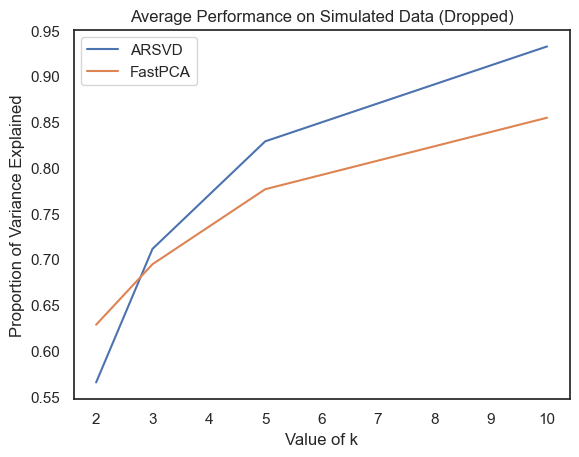

In [45]:
# Averages (datasets dropped)

plt.plot(k_vals, dropped_arsvd_avgs, label = "ARSVD")
plt.plot(k_vals, fastpca_avgs, label = "FastPCA")
plt.xlabel("Value of k")
plt.ylabel("Proportion of Variance Explained")
plt.title("Average Performance on Simulated Data (Dropped)")
plt.legend()

plt.savefig(f"{figure_dir}/dropped_arsvd_fastpca_avg.png")

In [94]:
# Averages by sparsity
sparsity_cutoff = 0.85
sparse_matrices = G_df[G_df["Proportion Zeros"] >= sparsity_cutoff]
sparse_matrices = sparse_matrices.reset_index()
sparse_matrices[["n", "sequence_length", "mut_rate"]] = pd.DataFrame(sparse_matrices["Parameters"].tolist())

sparse_matrices.drop(columns = ['index', 'Parameters', 'Shape of G'], inplace = True)

arsvd2_sparse = pd.merge(sparse_matrices, arsvd_2, on = ["n", "sequence_length", "mut_rate"])
arsvd3_sparse = pd.merge(sparse_matrices, arsvd_3, on = ["n", "sequence_length", "mut_rate"])
arsvd5_sparse = pd.merge(sparse_matrices, arsvd_5, on = ["n", "sequence_length", "mut_rate"])
arsvd10_sparse = pd.merge(sparse_matrices, arsvd_10, on = ["n", "sequence_length", "mut_rate"])

dense_matrices = G_df[G_df["Proportion Zeros"] < sparsity_cutoff]
dense_matrices = dense_matrices.reset_index()
dense_matrices[["n", "sequence_length", "mut_rate"]] = pd.DataFrame(dense_matrices["Parameters"].tolist())

dense_matrices.drop(columns = ['index', 'Parameters', 'Shape of G'], inplace = True)

arsvd2_dense = pd.merge(dense_matrices, arsvd_2, on = ["n", "sequence_length", "mut_rate"])
arsvd3_dense = pd.merge(dense_matrices, arsvd_3, on = ["n", "sequence_length", "mut_rate"])
arsvd5_dense = pd.merge(dense_matrices, arsvd_5, on = ["n", "sequence_length", "mut_rate"])
arsvd10_dense = pd.merge(dense_matrices, arsvd_10, on = ["n", "sequence_length", "mut_rate"])

fastpca2_sparse = pd.merge(sparse_matrices, fastpca_2, on = ["n", "sequence_length", "mut_rate"])
fastpca3_sparse = pd.merge(sparse_matrices, fastpca_3, on = ["n", "sequence_length", "mut_rate"])
fastpca5_sparse = pd.merge(sparse_matrices, fastpca_5, on = ["n", "sequence_length", "mut_rate"])
fastpca10_sparse = pd.merge(sparse_matrices, fastpca_10, on = ["n", "sequence_length", "mut_rate"])

fastpca2_dense = pd.merge(dense_matrices, fastpca_2, on = ["n", "sequence_length", "mut_rate"])
fastpca3_dense = pd.merge(dense_matrices, fastpca_3, on = ["n", "sequence_length", "mut_rate"])
fastpca5_dense = pd.merge(dense_matrices, fastpca_5, on = ["n", "sequence_length", "mut_rate"])
fastpca10_dense = pd.merge(dense_matrices, fastpca_10, on = ["n", "sequence_length", "mut_rate"])

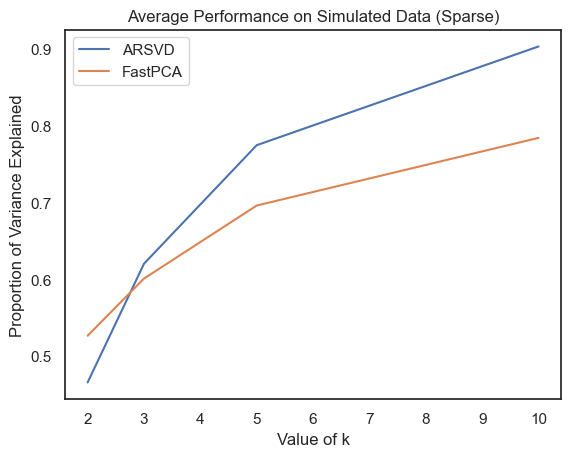

In [95]:
# Averages (sparse)

# Averaging performance across all datasets per k
arsvd_sparse_avgs = [arsvd2_sparse["Value"].mean(), arsvd3_sparse["Value"].mean(), arsvd5_sparse["Value"].mean(), arsvd10_sparse["Value"].mean()]
fastpca_sparse_avgs = [fastpca2_sparse["Value"].mean(), fastpca3_sparse["Value"].mean(), fastpca5_sparse["Value"].mean(), fastpca10_sparse["Value"].mean()]

plt.plot(k_vals, arsvd_sparse_avgs, label = "ARSVD")
plt.plot(k_vals, fastpca_sparse_avgs, label = "FastPCA")
plt.xlabel("Value of k")
plt.ylabel("Proportion of Variance Explained")
plt.title("Average Performance on Simulated Data (Sparse)")
plt.legend()

plt.savefig(f"{figure_dir}/sparse_arsvd_fastpca_avg.png")


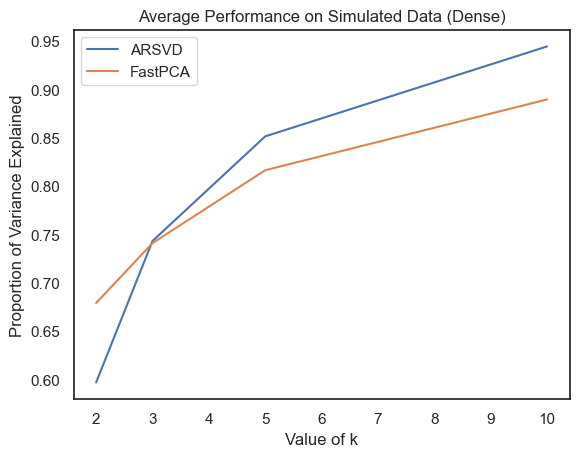

In [96]:
# Averages (dense)

# Averaging performance across all datasets per k
arsvd_dense_avgs = [arsvd2_dense["Value"].mean(), arsvd3_dense["Value"].mean(), arsvd5_dense["Value"].mean(), arsvd10_dense["Value"].mean()]
fastpca_dense_avgs = [fastpca2_dense["Value"].mean(), fastpca3_dense["Value"].mean(), fastpca5_dense["Value"].mean(), fastpca10_dense["Value"].mean()]

plt.plot(k_vals, arsvd_dense_avgs, label = "ARSVD")
plt.plot(k_vals, fastpca_dense_avgs, label = "FastPCA")
plt.xlabel("Value of k")
plt.ylabel("Proportion of Variance Explained")
plt.title("Average Performance on Simulated Data (Dense)")
plt.legend()

plt.savefig(f"{figure_dir}/dense_arsvd_fastpca_avg.png")
